<img src="../images/content_recommender.png" alt="1"
	title="" width="150" height="100" style="float:right;" >
<h4>Content recommender algorithms are given user preferences for items and recommend similar items based on a domain-specific notion of item contenttesting task</h4</img>

Compare features of products with the product user liked/purchased.
1.Cosine similarites
2. K means clustering

In [72]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
lemmatizer = WordNetLemmatizer()
import regex as re

In [164]:
ds = pd.read_csv("../data/cleaned_books.csv") 
ds.shape

(9964, 12)

In [166]:
ds = pd.get_dummies(ds, columns=['authors'])
ds.head(1)

,title,book_id,goodreads_book_id,original_publication_year,language_code,average_rating,ratings_count,description,num_pages,is_ebook,...,authors_4632,authors_4633,authors_4634,authors_4635,authors_4636,authors_4637,authors_4638,authors_4639,authors_4640,authors_4641
0,"Angels (Walsh Family, #3)",3998,82747,2002.0,en-US,3.73,25680,Maggie has always been the white sheep of the ...,448.0,False,...,0,0,0,0,0,0,0,0,0,0


In [179]:
ds['title_description'] = ds['title'] + " " + ds['description']
def create_bag_of_words(msg):
    #1 remove anything other than alphabets
    letters_only = re.sub("[^a-zA-Z]", " ", msg) # Remove non-letters.
    words = letters_only.lower().split()  #Convert to lower case, split into individual words.
    ps= PorterStemmer()
    base_words =[ps.stem(w) for w  in words] 
    return(" ".join(base_words))# 6. Join the words back into one string separated by space, 
ds['title_description'] = ds['title_description'].apply(create_bag_of_words)

In [77]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(ds['title_description'])
cosine_similarities = cosine_similarity(tfidf_matrix,tfidf_matrix)
cosine_similarities.shape

(9964, 9964)

In [167]:
ds.dtypes

title                         object
book_id                        int64
goodreads_book_id              int64
original_publication_year    float64
language_code                 object
                              ...   
authors_4637                   uint8
authors_4638                   uint8
authors_4639                   uint8
authors_4640                   uint8
authors_4641                   uint8
Length: 4653, dtype: object

In [84]:
def search_by_title(title):
    return ds.loc[ds['title'].str.lower().str.contains(title),['title','book_id']]

def book_title(book_id):
    return ds.loc[ds['book_id'] == book_id,'title'].values[0]

def build_nlp_content_recommender():
    #min_df : ignore terms that have a document frequency strictly lower than the given threshold
    tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0, stop_words='english')
    tfidf_matrix = tf.fit_transform(ds['title_description'])
    cosine_similarities = cosine_similarity(tfidf_matrix,tfidf_matrix)


def recommend_top_books(book_id, ds,cosine_similarities,n=2):
    idx =ds.index[ds['book_id'] ==book_id].values[0]
    
    closet_match_indices = cosine_similarities[idx].argsort()[:-10:-1] #stores 5 most similar books
    similar_items = [(np.round(cosine_similarities[idx][i],2), ds['book_id'][i],book_id) for i in closet_match_indices]
    print(f"You may also like to read: ")
    for rec in similar_items:
        print(f"-> {rec[2]} {book_title(rec[1])} score: {rec[0]} ")

In [79]:
# this takes long time to build similarity matrix
results =build_nlp_content_recommender() 

In [85]:
#3275 -Harry Potter Boxed Set, Books 1-5 (Harry Potter, #1-5)score
#8084 - Naked Economics: Undressing the Dismal Science
#3054 -Harry Potter and the Chamber of Secrets: Sheet Music for Flute with C.Dscore
#22
recommend_top_books(3275,ds,cosine_similarities,10)

You may also like to read: 
-> 3275 Harry Potter Boxed Set, Books 1-5 (Harry Potter, #1-5) score: 1.0 
-> 3275 Harry Potter and the Order of the Phoenix (Harry Potter, #5, Part 1) score: 0.58 
-> 3275 The Harry Potter Collection 1-4 (Harry Potter, #1-4) score: 0.54 
-> 3275 Harry Potter Boxset (Harry Potter, #1-7) score: 0.35 
-> 3275 Harry Potter and the Goblet of Fire (Harry Potter, #4) score: 0.33 
-> 3275 Harry Potter and the Chamber of Secrets: Sheet Music for Flute with C.D score: 0.33 
-> 3275 Harry Potter and the Cursed Child - Parts One and Two (Harry Potter, #8) score: 0.32 
-> 3275 Harry, a History: The True Story of a Boy Wizard, His Fans, and Life Inside the Harry Potter Phenomenon score: 0.31 
-> 3275 Harry Potter and the Chamber of Secrets (Harry Potter, #2) score: 0.31 


In [63]:
search_by_title('python')
ds[ds['book_id'] ==8084 ]

,title,book_id,goodreads_book_id,authors,original_publication_year,language_code,average_rating,ratings_count,description,num_pages,is_ebook,ratings_weight,title_description
4432,Naked Economics: Undressing the Dismal Science,8084,33293,Charles Wheelan,2002.0,NaN,4.0,5646,<em>Naked Economics</em> makes up for all of t...,288.0,False,>1000,Naked Economics: Undressing the Dismal Science


In [86]:
###  K means clustering
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [87]:
ds['is_ebook'] = ds['is_ebook'].astype(int) 

In [88]:
len(ds['authors'].unique())

4642

In [89]:
ds['original_publication_year']=ds['original_publication_year'].fillna(0)
ds['original_publication_year'].isna().sum()
ds['original_publication_year']= ds['original_publication_year'].astype(int)

In [90]:
ds['title_description'] = ds['title_description'].replace({"[^A-Za-z0-9 ]+": ""}, regex=True)

In [93]:
ds.isna().sum()

title                           0
book_id                         0
goodreads_book_id               0
authors                         0
original_publication_year       0
language_code                1071
average_rating                  0
ratings_count                   0
description                     0
num_pages                       0
is_ebook                        0
ratings_weight                  0
title_description               0
dtype: int64

In [92]:
col_list =['num_pages', 'is_ebook', 'original_publication_year','average_rating']
X = ds.loc[:, col_list]
sc = StandardScaler()
X_sc = sc.fit_transform(X)

In [94]:
df = pd.DataFrame(X, columns= col_list)

kmeans = KMeans(n_clusters=3)

y = kmeans.fit_predict(X_sc)

df['Cluster'] = y

In [95]:
df['Cluster'].value_counts()

0    9277
1     629
2      58
Name: Cluster, dtype: int64

In [96]:
# Check out centroids
kmeans.cluster_centers_,kmeans.labels_

(array([[  0.017831  ,  -0.26001838,   0.06486782,  -0.01972745],
        [ -0.24125042,   3.84588198,   0.18658096,   0.27874731],
        [ -0.23571885,  -0.11843561, -12.39893459,   0.13240494]]),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int32))

### elbow method to determine the optimal number of clusters for k-means clustering

,k,inertia,silhouette
0,2,29783.824064,0.623431
1,3,20850.791845,0.639402
2,4,15035.409620,0.349619
3,5,11345.692173,0.379803
4,6,9650.357016,0.337322
5,7,8356.074484,0.332398
6,8,7203.934150,0.339904
7,9,6522.654743,0.326470
8,10,6022.591917,0.318791
9,11,5578.636548,0.325792


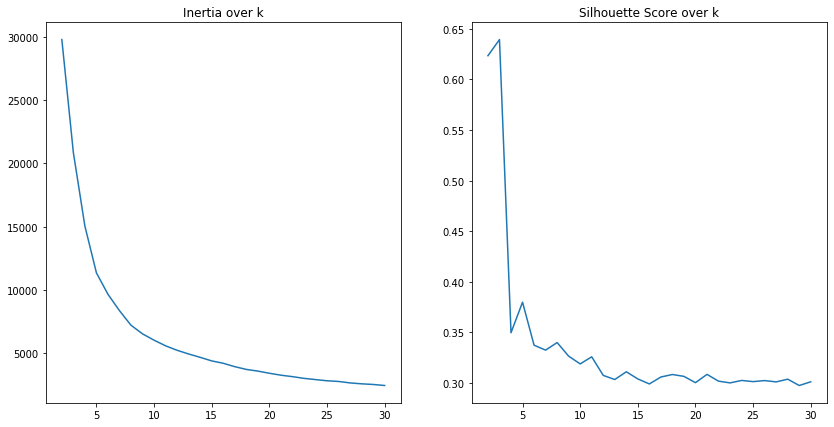

In [114]:
#Inertia - sum of squared errors for each cluster.
#low inertia = dense cluster

#silhoutte score -measure of how far apart clusters are. high Silhouette=> well separated clusters
def find_optimal_k(X_sc):
    scores = []
    for k in range(2, 31):
        cl = KMeans(n_clusters=k)
        cl.fit(X_sc)
        inertia = cl.inertia_  #
        sil = silhouette_score(X_sc, cl.labels_)
        scores.append([k, inertia, sil])  
    score_df = pd.DataFrame(scores)
    score_df.columns = ['k', 'inertia', 'silhouette']
    fig, axes = plt.subplots(1, 2, figsize=(14, 7))
    axes[0].plot(score_df.k, score_df.inertia)
    axes[0].set_title('Inertia over k')
    axes[1].plot(score_df.k, score_df.silhouette);
    axes[1].set_title('Silhouette Score over k')
    return score_df

find_optimal_k(X_sc)

 Notice how the elbow chart does not have a clear elbow. Instead, we see a fairly smooth curve, and it's unclear what is the best value of k to choose. In cases like this, we might try a different method for determining the optimal k, such as computing silhouette scores, or we might reevaluate whether clustering is the right thing to do on our data.

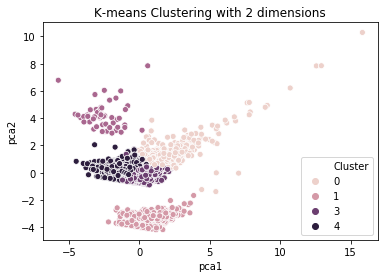

In [115]:
reduced_data = PCA(n_components=2).fit_transform(X_sc)
results = pd.DataFrame(reduced_data,columns=['pca1','pca2'])
sns.scatterplot(x="pca1", y="pca2", hue=df['Cluster'], data=results)
plt.title('K-means Clustering with 2 dimensions')
plt.show()

In [ ]:
#. Lets Apply K means clustering on the text data

In [116]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(ds['title_description'])
sc = StandardScaler()
X_sc = sc.fit_transform(X)

In [117]:
#Choosing k = 5
kmeans = KMeans(n_clusters=5)
y = kmeans.fit_predict(X_sc)
df['Cluster'] = y

In [118]:
df['Cluster'].value_counts()

0    4814
1    3729
4     739
3     625
2      57
Name: Cluster, dtype: int64

,k,inertia,silhouette
0,2,29783.824064,0.623431
1,3,23924.804928,0.339635
2,4,15035.413959,0.349736
3,5,11345.683757,0.379799
4,6,9650.183104,0.335244
5,7,8341.661838,0.332278
6,8,7203.937747,0.339904
7,9,6522.682612,0.326480
8,10,6093.427528,0.318448
9,11,5579.412723,0.325278


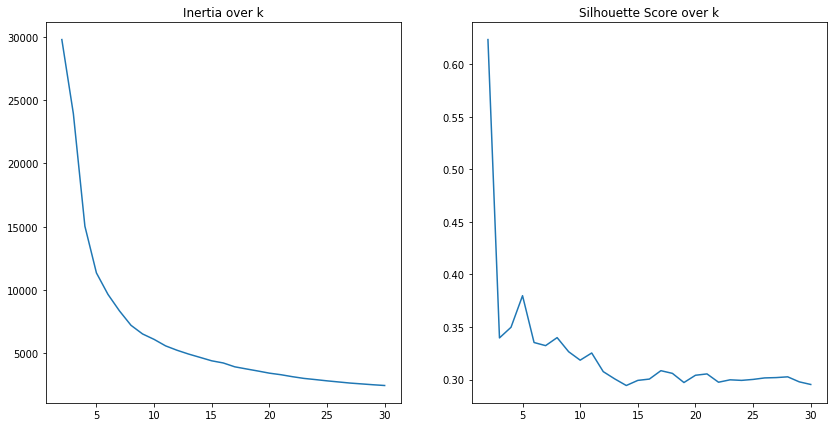

In [119]:
find_optimal_k(X_sc)

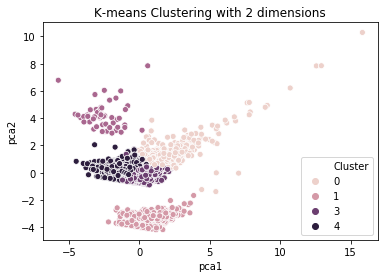

In [104]:
reduced_data = PCA(n_components=2).fit_transform(X_sc)
results = pd.DataFrame(reduced_data,columns=['pca1','pca2'])

sns.scatterplot(x="pca1", y="pca2", hue=df['Cluster'], data=results)
plt.title('K-means Clustering with 2 dimensions')
plt.show()

In [120]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [121]:
preprocess = ColumnTransformer(
    [
     ('authors', OneHotEncoder(dtype='int', handle_unknown='ignore'), ['authors']),
     ('title_description', TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0, stop_words='english'), 'title_description'),
    ],
    remainder='passthrough')

In [110]:
preprocess.

ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('authors',
                                 OneHotEncoder(categorical_features=None,
                                               categories=None, drop=None,
                                               dtype='int',
                                               handle_unknown='ignore',
                                               n_values=None, sparse=True),
                                 ['authors']),
                                ('title_description',
                                 TfidfVectorizer(analyzer='word', binary=False,
                                                 decode_error='str...
                                                 dtype=<class 'numpy.float64'>,
                                                 encoding='utf-8',
                                                 input='content',
             

In [169]:
kmeans = KMeans(n_clusters=5)
y = kmeans.fit_predict(X_sc)
ds['Cluster'] = y

In [176]:

cluster_df.head(1)

,title,book_id,goodreads_book_id,original_publication_year,language_code,average_rating,ratings_count,description,num_pages,is_ebook,...,authors_4633,authors_4634,authors_4635,authors_4636,authors_4637,authors_4638,authors_4639,authors_4640,authors_4641,Cluster
5,"1,000 Places to See Before You Die",2618,11525,2003.0,NaN,3.83,33025,"Around the World, continent by continent, here...",992.0,False,...,0,0,0,0,0,0,0,0,0,3


In [178]:
ds

,title,book_id,goodreads_book_id,original_publication_year,language_code,average_rating,ratings_count,description,num_pages,is_ebook,...,authors_4633,authors_4634,authors_4635,authors_4636,authors_4637,authors_4638,authors_4639,authors_4640,authors_4641,Cluster
0,"Angels (Walsh Family, #3)",3998,82747,2002.0,en-US,3.73,25680,Maggie has always been the white sheep of the ...,448.0,False,...,0,0,0,0,0,0,0,0,0,0
1,"""حكايات فرغلي المستكاوي ""حكايتى مع كفر السحلاوية",9610,17339590,2013.0,ara,3.57,7443,حكايات فرغلي المستكاوي، قصص من الرعب الساخر<br...,127.0,False,...,0,0,0,0,0,0,0,0,0,0
2,#GIRLBOSS,2855,18667945,2014.0,eng,3.71,40090,In the New York Times bestseller that the Wash...,256.0,False,...,0,0,0,0,0,0,0,0,0,0
3,'Salem's Lot,349,11590,1975.0,en-GB,4.12,301477,Thousands of miles away from the small townshi...,483.0,False,...,0,0,0,0,0,0,0,0,0,4
4,"'Tis (Frank McCourt, #2)",2252,4912,1999.0,eng,3.66,40726,The sequel to Frank McCourt's memoir of his Ir...,495.0,False,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9959,واحة الغروب,8247,3240691,2006.0,ara,3.82,10365,هذه الرواية حاصلة على الجائزة العالمية للرواية...,325.0,False,...,0,0,0,0,0,0,0,0,0,0
9960,يوتوبيا,2588,3503947,2008.0,ara,3.90,31669,كيف ستكون مصر عام 2023؟<br />لقد عزَلَ الأغنيا...,192.0,False,...,0,0,0,0,0,0,0,0,0,0
9961,ڤيرتيجو,3538,3831279,2007.0,ara,3.72,17001,منذ سقط الحارس الأول ضغط بأعصابه على زر التصوي...,402.0,False,...,0,0,0,0,0,0,0,0,0,0
9962,キスよりも早く1 [Kisu Yorimo Hayaku 1] (Faster than a...,9321,8110748,2007.0,jpn,4.23,11232,"Losing their parents, Fumiko and her brother h...",188.0,False,...,0,0,0,0,0,0,0,0,0,4


In [194]:
    c= ds.loc[ds['book_id'] ==3275,'Cluster'].values[0]

    #cluster_df = ds[ds['Cluster']==c]
    #print(f"cluster for {book_id} is {c}")

3

In [211]:
def recommend_top_books_incluster(book_id, ds,n=2):
    c = ds.loc[ds['book_id'] ==book_id,'Cluster'].values[0]
    cluster_df = ds[ds['Cluster']==c]
    cluster_df.reset_index(inplace=True)
    print(f"cluster for {book_id} is {c}  {len(cluster_df['title_description'])}")
    
    tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0, stop_words='english')
    tfidf_matrix = tf.fit_transform(cluster_df['title_description'])
    
    cosine_similarities = cosine_similarity(tfidf_matrix,tfidf_matrix)
    idx =cluster_df.index[cluster_df['book_id'] ==book_id].values[0]
    
    closet_match_indices = cosine_similarities[idx].argsort()[:-5:-1] 

    similar_items = [(np.round(cosine_similarities[idx][i],2), ds['book_id'][i],book_id) for i in closet_match_indices]
    print(f"You may also like to read: ")
    for rec in similar_items:
        print(f"-> {rec[2]} {book_title(rec[1])} score: {rec[0]} ")
        
recommend_top_books_incluster(3275,ds)


cluster for 3275 is 3  739
You may also like to read: 
-> 3275 A Man Without a Country score: 1.0 
-> 3275 An Artist of the Floating World score: 0.59 
-> 3275 A Man in Full score: 0.4 
-> 3275 A Matter of Honor score: 0.37 


In [349]:
#https://datascience.stackexchange.com/questions/48693/perform-k-means-clustering-over-multiple-columns
https://www.kaggle.com/zygmunt/goodbooks-10k#tags.csv

https://www.kdnuggets.com/2019/11/content-based-recommender-using-natural-language-processing-nlp.html


https://towardsdatascience.com/how-to-build-from-scratch-a-content-based-movie-recommender-with-natural-language-processing-25ad400eb243

https://towardsdatascience.com/my-journey-to-building-book-recommendation-system-5ec959c41847


https://www.linkedin.com/pulse/content-based-recommender-engine-under-hood-venkat-raman/

In [ ]:
    tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0, stop_words='english')
    tfidf_matrix = tf.fit_transform(ds['title_description'])
    cosine_similarities = cosine_similarity(tfidf_matrix,tfidf_matrix)